In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

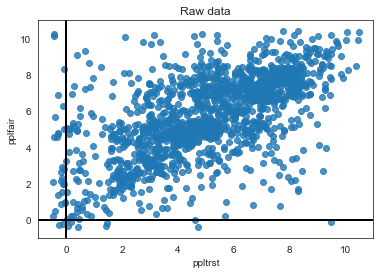

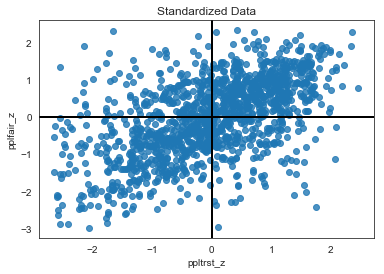

In [2]:
# Make the scatterplot matrix

# Setting the default plot aesthetics to be prettier
sns.set_style('white')

df = pd.read_csv('essdata_thinkful.csv')

# Take a subset of the data for PCA.  This limits to Swiss and Czech data from 2012
# and keeps only specific columns
df_pca = df.loc[
    ((df['cntry'] == 'CZ') | (df['cntry'] == 'CH')) & (df['year'] == 6),
    ['tvtot', 'ppltrst', 'pplfair', 'pplhlp']
].dropna()

t = sns.regplot(
    'ppltrst',
    'pplfair',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.set(xlim=(-1, 11), ylim=(-1, 11))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()

# Standardizing variables by subtracting the mean and dividing by the standard deviation
# Now both variables are on the same scale
df_pca['ppltrst_z'] = (df_pca['ppltrst'] - df_pca['ppltrst'].mean()) / df_pca['ppltrst'].std()
df_pca['pplfair_z'] = (df_pca['pplfair'] - df_pca['pplfair'].mean()) / df_pca['pplfair'].std()

t = sns.regplot(
    'ppltrst_z',
    'pplfair_z',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized Data')
plt.show()

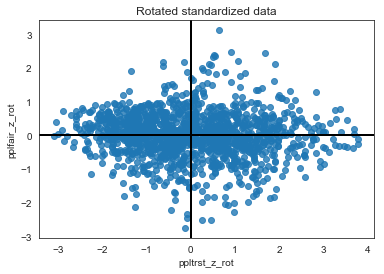

In [3]:
# Rotating the data so that the axes roughly match to vector above
df_pca['ppltrst_z_rot'] = math.cos(40) * df_pca['ppltrst_z'] - math.sin(40) * df_pca['pplfair_z']
df_pca['pplfair_z_rot'] = math.sin(40) * df_pca['ppltrst_z'] + math.cos(40) * df_pca['pplfair_z']

t = sns.regplot(
    'ppltrst_z_rot',
    'pplfair_z_rot',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()

In [4]:
# Take a subset of the data for PCA and drop missing values because PCA cannot
# handle them. We could also impute, but missingness is quite low so dropping
# missing rows is unlikely to create bias.
df_pca = df.loc[
    ((df['cntry'] == 'CZ') | (df['cntry'] == 'CH')) & (df['year']==6),
    ['tvtot','ppltrst','pplfair','pplhlp']
].dropna()

# Normalize the data so that all variables have a mean of 0 and standard deviation of 1
X = StandardScaler().fit_transform(df_pca)

# The NumPy covariance functioj assumes that variables are represented by rows
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00071174 -0.24535312 -0.23531159 -0.17820482]
 [-0.24535312  1.00071174  0.60528939  0.49609931]
 [-0.23531159  0.60528939  1.00071174  0.53193085]
 [-0.17820482  0.49609931  0.53193085  1.00071174]]


In [8]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 4).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')
    
print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.30084526]
 [ 0.55945823]
 [ 0.5681188 ]
 [ 0.52320135]]
Eigenvalue 1: 2.2112568631998233
----------------------------------------
Eigenvector 2: 
[[0.94786152]
 [0.11600843]
 [0.15403897]
 [0.25371751]]
Eigenvalue 2: 0.8847413570711697
----------------------------------------
Eigenvector 3: 
[[ 0.10491426]
 [ 0.51597659]
 [ 0.28505945]
 [-0.80093836]]
Eigenvalue 3: 0.5151421389236885
----------------------------------------
Eigenvector 4: 
[[ 0.00660771]
 [ 0.63821367]
 [-0.75647481]
 [ 0.14277786]]
Eigenvalue 4: 0.3917066158942856
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.55242103 0.22102802 0.12869394 0.097857  ]


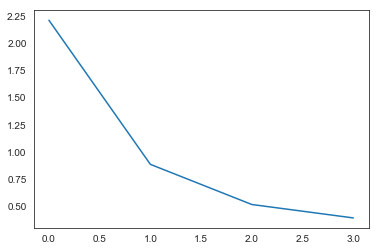

In [9]:
plt.plot(eig_val_cov)
plt.show()

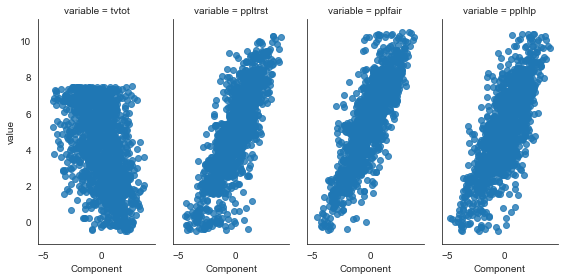

In [12]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X
P = eig_vec_cov[:, 0]

# Transform X into Y
Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes
data_to_plot = df_pca[['tvtot', 'ppltrst', 'pplfair', 'pplhlp']]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col='variable', height=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.55242103 0.22102802 0.12869394 0.097857  ]


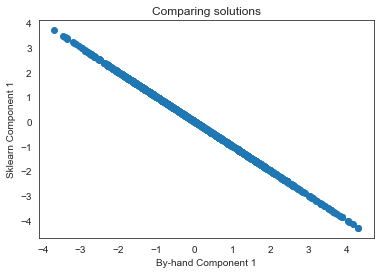

In [13]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours - a perfect match
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()